# Taking frames from video clips using CV2

##### Matthew Johnson, 2019


TODO:
- Increase dataset size by x amount
- Implement top cropping (for squads/non-squads classification)
- Begin model building for ^ and pass/run/fake ( find more fakes for class balance )


- Cropping:
    - **Top piece**
        - Classify as H2H, Squads, or Solo.
        - maybe binary classification? squads/not squads
    - Bottom piece 
        - Classify Touchdown, Interception OR maybe defensive/offensive?
        - Classify as Verticals, WR Post, HB Pitch, Fake FG, etc.
        


In [1]:
import cv2
import os
import pandas as pd
RUN_INDEX=4

save_path = 'saved_frames'
user_save_path = 'users'

folder_path = '/Volumes/PS4 MyPassp/PS4/SHARE/Video Clips/Madden NFL 19'

for path in [save_path, user_save_path]:
    if not os.path.isdir(path):
        os.mkdir(path)


def extract_final_frame(video_file, path=save_path):
    
    video_path = os.path.join(folder_path, video_file)

    # Opens the Video file
    cap= cv2.VideoCapture(video_path)
    i=0
    frame_holder = None
    
    while(cap.isOpened()):
        ret, frame = cap.read()
        
        if ret:
            frame_holder = frame  
        else:
            break    
        i+=1

    save_prefix = video_file.rstrip('.mp4')
    save_filename = f'{path}/{save_prefix}-frame{i}.jpg'
    cv2.imwrite(save_filename, frame_holder)
    cap.release()
    cv2.destroyAllWindows()
    
    # 
    suffix = video_file.rstrip('.mp4').split('_')[-1]
    entry = {'video_file': video_file,
              'cap_file': save_filename,
              'date': suffix
             }
    return entry


def get_todo_filenames():
    
    clip_file = f'may19_caps_{RUN_INDEX-1}.csv'
    if os.path.isfile(clip_file):
        all_clips = pd.read_csv(clip_file)
        all_clips = all_clips[ pd.isnull(all_clips['cap_file'])]
        todo_files = all_clips['video_file'].values
    else:
        #source_path = '/Volumes/PS4 MyPassp/PS4/SHARE/Video Clips/Madden NFL 19'
        #todo_files = [f for f in os.listdir(source_path) if f.endswith('.mp4')]
        print('ERROR')
        
    return todo_files


# ...

In [2]:
#
filenames = get_todo_filenames()

df2 = pd.DataFrame({'video_file': filenames})
df2['date'] = df2['video_file'].str.split('Madden NFL 19_').apply(lambda x: x[1]).str[:8]
df2['date'] = pd.to_datetime(df2['date'], format='%Y%m%d', errors='coerce')
df2.sort_values('date', ascending=False, inplace=True)
df2.reset_index(drop=True, inplace=True)

In [3]:
filenames = df2['video_file'].values

In [4]:
stop_idx = min(400, len(filenames))
print(f'{len(filenames)} video files available... extracting {stop_idx}.')
data_entries = [extract_final_frame(file) for file in filenames[:stop_idx]]
df = pd.DataFrame(data_entries)

1321 video files available... extracting 400.


In [5]:
newdf = pd.concat([df2, df], axis=1).iloc[:,:-2]
newdf.head()

,video_file,date,cap_file
0,Madden NFL 19_20190315174740.mp4,2019-03-15,saved_frames/Madden NFL 19_20190315174740-fram...
1,Madden NFL 19_20190314084648.mp4,2019-03-14,saved_frames/Madden NFL 19_20190314084648-fram...
2,Madden NFL 19_20190313103442.mp4,2019-03-13,saved_frames/Madden NFL 19_20190313103442-fram...
3,Madden NFL 19_20190313192832.mp4,2019-03-13,saved_frames/Madden NFL 19_20190313192832-fram...
4,Madden NFL 19_20190313202516.mp4,2019-03-13,saved_frames/Madden NFL 19_20190313202516-fram...


In [6]:
newdf.to_csv(f'may19_caps_{RUN_INDEX}.csv')

## Cropping

In [7]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

save_path = 'saved_plays'

x = 0
y = 25
h = 140-y
w = 1280
play_width = 347
play_height = 206
play_loc_r = (423, 821)
play_loc_l = (423, 94)

def crop_image_top(img_name):
    # Open Image
    image = cv2.imread(img_name)
    # Crop Image
    crop_img = image[y:y+h, :]
    
    left = crop_img[:, 72:262]
    right = crop_img[:, 1015:1208]
    
    # Combine
    concat_img = np.concatenate([left, right], axis=1)
    fn = save_file(concat_img, img_name, user_save_path)
    # TODO: add change to save_file so to save to 'users/' not 'saved_plays'
    return fn

def crop_image_play(img_name):
    # Open Image
    image = cv2.imread(img_name)
    # Crop Image
    left = image[play_loc_l[0]:play_loc_l[0]+play_height, play_loc_l[1]:play_loc_l[1]+play_width]
    right = image[play_loc_r[0]:play_loc_r[0]+play_height, play_loc_r[1]:play_loc_r[1]+play_width]
    # Combine
    concat_img = np.concatenate([left, right], axis=1) #
    fn = save_file(concat_img, img_name)
    return fn

def save_file(item, filename, path=save_path):
    filename = filename.lstrip('saved_frames/')
    save_filename = f'{path}/{filename.rstrip(".jpg")}-play.jpg'
    cv2.imwrite(save_filename, item)
    return save_filename

### Bottom

In [8]:
newdf2 = newdf.dropna().copy()
newdf2['play_image'] = newdf2['cap_file'].apply(lambda x: crop_image_play(x))

In [9]:
newdf2.to_csv('temp_with_sides_m19_run4.csv')

In [10]:
newdf2['user_image'] = newdf2['cap_file'].apply(lambda x: crop_image_top(x))

In [11]:
newdf2.head()

,video_file,date,cap_file,play_image,user_image
0,Madden NFL 19_20190315174740.mp4,2019-03-15,saved_frames/Madden NFL 19_20190315174740-fram...,saved_plays/Madden NFL 19_20190315174740-frame...,users/Madden NFL 19_20190315174740-frame1774-p...
1,Madden NFL 19_20190314084648.mp4,2019-03-14,saved_frames/Madden NFL 19_20190314084648-fram...,saved_plays/Madden NFL 19_20190314084648-frame...,users/Madden NFL 19_20190314084648-frame467-pl...
2,Madden NFL 19_20190313103442.mp4,2019-03-13,saved_frames/Madden NFL 19_20190313103442-fram...,saved_plays/Madden NFL 19_20190313103442-frame...,users/Madden NFL 19_20190313103442-frame1781-p...
3,Madden NFL 19_20190313192832.mp4,2019-03-13,saved_frames/Madden NFL 19_20190313192832-fram...,saved_plays/Madden NFL 19_20190313192832-frame...,users/Madden NFL 19_20190313192832-frame1725-p...
4,Madden NFL 19_20190313202516.mp4,2019-03-13,saved_frames/Madden NFL 19_20190313202516-fram...,saved_plays/Madden NFL 19_20190313202516-frame...,users/Madden NFL 19_20190313202516-frame1717-p...


In [12]:
newdf2.to_csv('temp_with_users_m19_run4.csv')2

## Labeling (Left, Right, Neither)
Do Manual Labelling by dragging and dropping into subfolders of saved_plays: left, right, neither

In [13]:
dic = {}
for _ in ['left', 'right', 'neither']:
    files = os.listdir(os.path.join('saved_plays', _))
    files = [f for f in files if f.endswith('.jpg')]

    for file in files:
        dic[file] = _

In [14]:
newdf2['play_side'] = newdf2['play_image'].apply(lambda x: dic[x.lstrip('saved_plays/')])

In [15]:
newdf2.head()

,video_file,date,cap_file,play_image,user_image,play_side
0,Madden NFL 19_20190315174740.mp4,2019-03-15,saved_frames/Madden NFL 19_20190315174740-fram...,saved_plays/Madden NFL 19_20190315174740-frame...,users/Madden NFL 19_20190315174740-frame1774-p...,right
1,Madden NFL 19_20190314084648.mp4,2019-03-14,saved_frames/Madden NFL 19_20190314084648-fram...,saved_plays/Madden NFL 19_20190314084648-frame...,users/Madden NFL 19_20190314084648-frame467-pl...,right
2,Madden NFL 19_20190313103442.mp4,2019-03-13,saved_frames/Madden NFL 19_20190313103442-fram...,saved_plays/Madden NFL 19_20190313103442-frame...,users/Madden NFL 19_20190313103442-frame1781-p...,right
3,Madden NFL 19_20190313192832.mp4,2019-03-13,saved_frames/Madden NFL 19_20190313192832-fram...,saved_plays/Madden NFL 19_20190313192832-frame...,users/Madden NFL 19_20190313192832-frame1725-p...,right
4,Madden NFL 19_20190313202516.mp4,2019-03-13,saved_frames/Madden NFL 19_20190313202516-fram...,saved_plays/Madden NFL 19_20190313202516-frame...,users/Madden NFL 19_20190313202516-frame1717-p...,right


In [16]:
newdf2.tail()

,video_file,date,cap_file,play_image,user_image,play_side
395,Madden NFL 19_20190213151503.mp4,2019-02-13,saved_frames/Madden NFL 19_20190213151503-fram...,saved_plays/Madden NFL 19_20190213151503-frame...,users/Madden NFL 19_20190213151503-frame1717-p...,left
396,Madden NFL 19_20190212133257.mp4,2019-02-12,saved_frames/Madden NFL 19_20190212133257-fram...,saved_plays/Madden NFL 19_20190212133257-frame...,users/Madden NFL 19_20190212133257-frame1790-p...,right
397,Madden NFL 19_20190212134511.mp4,2019-02-12,saved_frames/Madden NFL 19_20190212134511-fram...,saved_plays/Madden NFL 19_20190212134511-frame...,users/Madden NFL 19_20190212134511-frame1781-p...,right
398,Madden NFL 19_20190212153547.mp4,2019-02-12,saved_frames/Madden NFL 19_20190212153547-fram...,saved_plays/Madden NFL 19_20190212153547-frame...,users/Madden NFL 19_20190212153547-frame1772-p...,right
399,Madden NFL 19_20190212130011.mp4,2019-02-12,saved_frames/Madden NFL 19_20190212130011-fram...,saved_plays/Madden NFL 19_20190212130011-frame...,users/Madden NFL 19_20190212130011-frame1489-p...,left


In [17]:
newdf2.to_csv(f'may19_withplay_{RUN_INDEX}.csv')

In [18]:
newdf2.shape

(400, 6)

### Combining previous DFs (change)

In [19]:
a = pd.read_csv('may19_withplay_1.csv', index_col=0)
b = pd.read_csv('may19_withplay_2.csv', index_col=0)
c = pd.read_csv('may19_withplay_3.csv', index_col=0)
d = pd.read_csv('may19_withplay_4.csv', index_col=0)

cdf = pd.concat([a, b], axis=0)
cdf = pd.concat([cdf, c], axis=0)
cdf = pd.concat([cdf, d], axis=0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [20]:
cdf['play_side'].value_counts()

right      456
left       422
neither    222
Name: play_side, dtype: int64

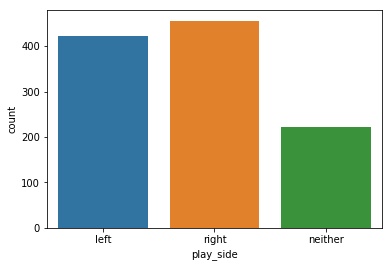

In [21]:
sns.countplot(cdf['play_side']);

## Play Type Labelling (Pass, Run, Fake)
- Manually label like previous

In [22]:
dic = {}
for _ in ['left', 'right']:
    for play in ['run', 'pass', 'fake']:
        files = os.listdir(os.path.join(f'saved_plays/{_}', play))
        files = [f for f in files if f.endswith('.jpg')]

        for file in files:
            dic[file] = play

In [23]:
newdf3 = cdf[ cdf['play_side']!='neither' ].copy()
newdf3['play_type'] = newdf3['play_image'].apply(lambda x: dic[x.lstrip('saved_plays/')])

In [24]:
newdf3.head()

,cap_file,date,play_image,play_side,user_image,video_file,play_type
0,saved_frames/Madden NFL 19_2019051819382-frame...,2019-05-18,saved_plays/Madden NFL 19_2019051819382-frame1...,left,NaN,Madden NFL 19_20190518193824.mp4,run
1,saved_frames/Madden NFL 19_20190518194258-fram...,2019-05-18,saved_plays/Madden NFL 19_20190518194258-frame...,left,NaN,Madden NFL 19_20190518194258.mp4,run
2,saved_frames/Madden NFL 19_20190518193848-fram...,2019-05-18,saved_plays/Madden NFL 19_20190518193848-frame...,left,NaN,Madden NFL 19_20190518193848.mp4,run
3,saved_frames/Madden NFL 19_20190518193117-fram...,2019-05-18,saved_plays/Madden NFL 19_20190518193117-frame...,right,NaN,Madden NFL 19_20190518193117.mp4,pass
4,saved_frames/Madden NFL 19_20190518192339-fram...,2019-05-18,saved_plays/Madden NFL 19_20190518192339-frame...,right,NaN,Madden NFL 19_20190518192339.mp4,run


In [25]:
newdf3['play_type'].value_counts()

pass    580
run     263
fake     35
Name: play_type, dtype: int64

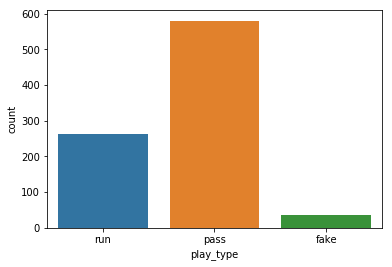

In [26]:
sns.countplot(newdf3['play_type']);

In [27]:
newdf3.to_csv(f'may19_with_type_{RUN_INDEX}.csv')

## Squads/Not-Squads Labelling

In [35]:
dic = {}
for _ in ['squads', 'notsquads']:
    files = os.listdir(os.path.join(f'users', _))
    files = [f for f in files if f.endswith('.jpg')]

    for file in files:
        dic[file] = _

In [40]:
newdf2['squads'] = newdf2['user_image'].apply(lambda x: dic[x.lstrip('users/')])

In [43]:
newdf2.head()

,video_file,date,cap_file,play_image,user_image,play_side,squads
0,Madden NFL 19_20190315174740.mp4,2019-03-15,saved_frames/Madden NFL 19_20190315174740-fram...,saved_plays/Madden NFL 19_20190315174740-frame...,users/Madden NFL 19_20190315174740-frame1774-p...,right,notsquads
1,Madden NFL 19_20190314084648.mp4,2019-03-14,saved_frames/Madden NFL 19_20190314084648-fram...,saved_plays/Madden NFL 19_20190314084648-frame...,users/Madden NFL 19_20190314084648-frame467-pl...,right,notsquads
2,Madden NFL 19_20190313103442.mp4,2019-03-13,saved_frames/Madden NFL 19_20190313103442-fram...,saved_plays/Madden NFL 19_20190313103442-frame...,users/Madden NFL 19_20190313103442-frame1781-p...,right,notsquads
3,Madden NFL 19_20190313192832.mp4,2019-03-13,saved_frames/Madden NFL 19_20190313192832-fram...,saved_plays/Madden NFL 19_20190313192832-frame...,users/Madden NFL 19_20190313192832-frame1725-p...,right,notsquads
4,Madden NFL 19_20190313202516.mp4,2019-03-13,saved_frames/Madden NFL 19_20190313202516-fram...,saved_plays/Madden NFL 19_20190313202516-frame...,users/Madden NFL 19_20190313202516-frame1717-p...,right,notsquads


In [44]:
newdf2.to_csv(f'game_type_{RUN_INDEX}.csv')

In [45]:
newdf2['squads'].value_counts()

squads       266
notsquads    134
Name: squads, dtype: int64

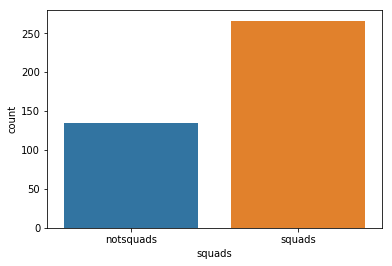

In [46]:
sns.countplot(newdf2['squads']);